# deep learning character level models

## V1: IndoBERT merge text feature only

In [1]:
import os
import pandas as pd
import torch
import numpy as np
import random
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# === Configuration ===
FOLDS = 5
EPOCHS = 15
BATCH_SIZE = 8
MODEL_NAME = "indobenchmark/indobert-base-p1"
OUTPUT_DIR = "results/V1_IndoBERT_Char"
SEED = 42

os.makedirs(OUTPUT_DIR, exist_ok=True)

# === Seed setup ===
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# === Load dataset ===
df = pd.read_csv("character_level.csv")
df["merged_text"] = df["merged_text"].fillna("")

# Encode labels
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["type"])
texts = df["merged_text"].tolist()
labels = df["label"].tolist()

# === Compute class weights ===
class_counts = np.bincount(labels)
class_weights = len(labels) / (len(class_counts) * class_counts)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# === Dataset class ===
class CharacterDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_len)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# === Metrics ===
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# === Tokenizer ===
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# === K-Fold setup ===
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
fold_metrics = []
cumulative_cm = np.zeros((3, 3), dtype=int)

for fold, (train_idx, val_idx) in enumerate(skf.split(texts, labels)):
    print(f"\n📚 Fold {fold + 1}/{FOLDS}")

    train_texts = [texts[i] for i in train_idx]
    val_texts = [texts[i] for i in val_idx]
    train_labels = [labels[i] for i in train_idx]
    val_labels = [labels[i] for i in val_idx]

    train_dataset = CharacterDataset(train_texts, train_labels, tokenizer)
    val_dataset = CharacterDataset(val_texts, val_labels, tokenizer)

    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)
    model.classifier.weight.data = model.classifier.weight.data.to(class_weights_tensor.device) * class_weights_tensor.unsqueeze(1)

    fold_dir = os.path.join(OUTPUT_DIR, f"fold_{fold+1}")
    os.makedirs(fold_dir, exist_ok=True)

    training_args = TrainingArguments(
        output_dir=fold_dir,
        num_train_epochs=EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        logging_dir=os.path.join(fold_dir, "logs"),
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        logging_steps=50,
        disable_tqdm=True,
        learning_rate=2e-5,
        warmup_steps=100,
        weight_decay=0.01,
        seed=SEED
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    trainer.train()

    # Evaluate
    predictions = trainer.predict(val_dataset)
    preds = torch.argmax(torch.tensor(predictions.predictions), dim=1).numpy()
    true_labels = np.array(val_labels)
    pred_labels = preds

    decoded_true = label_encoder.inverse_transform(true_labels)
    decoded_pred = label_encoder.inverse_transform(pred_labels)

    # Classification Report
    report = classification_report(decoded_true, decoded_pred, output_dict=True, digits=4)
    report_df = pd.DataFrame(report).transpose()
    report_df.to_csv(os.path.join(fold_dir, "classification_report.csv"))

    # Confusion Matrix
    cm = confusion_matrix(decoded_true, decoded_pred, labels=label_encoder.classes_)
    cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)
    cumulative_cm += cm

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - Fold {fold + 1} (IndoBERT V1 - Char Level)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(os.path.join(fold_dir, "confusion_matrix.png"))
    plt.close()

    macro = report["macro avg"]
    fold_metrics.append({
        "Fold": fold + 1,
        "Precision": macro["precision"],
        "Recall": macro["recall"],
        "F1-score": macro["f1-score"],
        "Accuracy": accuracy_score(decoded_true, decoded_pred)
    })

# === Save summary and average
summary_df = pd.DataFrame(fold_metrics)
summary_df.loc["Average"] = summary_df.mean(numeric_only=True)
summary_df.to_csv(os.path.join(OUTPUT_DIR, "summary.csv"), index=False)

# === Save Average Confusion Matrix
avg_cm = cumulative_cm // FOLDS
avg_cm_df = pd.DataFrame(avg_cm, index=label_encoder.classes_, columns=label_encoder.classes_)
plt.figure(figsize=(6, 5))
sns.heatmap(avg_cm_df, annot=True, fmt='d', cmap='Purples')
plt.title("Average Confusion Matrix (IndoBERT V1 - Char Level)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "average_confusion_matrix.png"))
plt.close()

print("\n✅ IndoBERT V1 character-level training complete. Results saved to:", OUTPUT_DIR)
print(summary_df)

def notify_done(path=r'C:\Users\rayssa\Downloads\fein.mp3'):
    import os
    if os.path.exists(path):
        os.startfile(path)
    else:
        print("⚠️ Notification sound file not found!")

# Call it at the end
notify_done()



c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



📚 Fold 1/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.9404398798942566, 'eval_accuracy': 0.5384615384615384, 'eval_f1': 0.2333333333333333, 'eval_precision': 0.1794871794871795, 'eval_recall': 0.3333333333333333, 'eval_runtime': 0.2239, 'eval_samples_per_second': 174.147, 'eval_steps_per_second': 22.327, 'epoch': 1.0}


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.9238206744194031, 'eval_accuracy': 0.5384615384615384, 'eval_f1': 0.3047433398310591, 'eval_precision': 0.30303030303030304, 'eval_recall': 0.3528693528693529, 'eval_runtime': 0.2167, 'eval_samples_per_second': 179.94, 'eval_steps_per_second': 23.069, 'epoch': 2.0}
{'loss': 0.9788, 'grad_norm': 5.70477819442749, 'learning_rate': 1e-05, 'epoch': 2.6315789473684212}
{'eval_loss': 0.8688951134681702, 'eval_accuracy': 0.5384615384615384, 'eval_f1': 0.4444444444444444, 'eval_precision': 0.6520763187429854, 'eval_recall': 0.4231990231990232, 'eval_runtime': 0.2045, 'eval_samples_per_second': 190.755, 'eval_steps_per_second': 24.456, 'epoch': 3.0}
{'eval_loss': 0.8547136187553406, 'eval_accuracy': 0.5897435897435898, 'eval_f1': 0.47338935574229696, 'eval_precision': 0.7000000000000001, 'eval_recall': 0.45494505494505494, 'eval_runtime': 0.2069, 'eval_samples_per_second': 188.5, 'eval_steps_per_second': 24.167, 'epoch': 4.0}
{'eval_loss': 0.7920941710472107, 'eval_accuracy': 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.9625915884971619, 'eval_accuracy': 0.5526315789473685, 'eval_f1': 0.3520531400966183, 'eval_precision': 0.33108866442199775, 'eval_recall': 0.38095238095238093, 'eval_runtime': 0.1595, 'eval_samples_per_second': 238.315, 'eval_steps_per_second': 31.357, 'epoch': 1.0}
{'eval_loss': 0.8894913196563721, 'eval_accuracy': 0.5526315789473685, 'eval_f1': 0.43813131313131315, 'eval_precision': 0.6432098765432099, 'eval_recall': 0.41984126984126985, 'eval_runtime': 0.2009, 'eval_samples_per_second': 189.133, 'eval_steps_per_second': 24.886, 'epoch': 2.0}
{'loss': 0.9466, 'grad_norm': 11.903669357299805, 'learning_rate': 1e-05, 'epoch': 2.5}


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.0214297771453857, 'eval_accuracy': 0.5526315789473685, 'eval_f1': 0.3358070500927644, 'eval_precision': 0.3142857142857143, 'eval_recall': 0.36904761904761907, 'eval_runtime': 0.1915, 'eval_samples_per_second': 198.429, 'eval_steps_per_second': 26.109, 'epoch': 3.0}


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.0021846294403076, 'eval_accuracy': 0.5526315789473685, 'eval_f1': 0.2413793103448276, 'eval_precision': 0.18918918918918917, 'eval_recall': 0.3333333333333333, 'eval_runtime': 0.1742, 'eval_samples_per_second': 218.194, 'eval_steps_per_second': 28.71, 'epoch': 4.0}
{'train_runtime': 18.0017, 'train_samples_per_second': 127.488, 'train_steps_per_second': 16.665, 'train_loss': 0.8755291938781739, 'epoch': 4.0}

📚 Fold 3/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.9875288605690002, 'eval_accuracy': 0.5526315789473685, 'eval_f1': 0.23728813559322035, 'eval_precision': 0.1842105263157895, 'eval_recall': 0.3333333333333333, 'eval_runtime': 0.1482, 'eval_samples_per_second': 256.411, 'eval_steps_per_second': 33.738, 'epoch': 1.0}


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.9028949737548828, 'eval_accuracy': 0.5789473684210527, 'eval_f1': 0.2932330827067669, 'eval_precision': 0.36111111111111116, 'eval_recall': 0.3611111111111111, 'eval_runtime': 0.1664, 'eval_samples_per_second': 228.312, 'eval_steps_per_second': 30.041, 'epoch': 2.0}
{'loss': 0.9649, 'grad_norm': 4.485864162445068, 'learning_rate': 1e-05, 'epoch': 2.5}


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.82296222448349, 'eval_accuracy': 0.631578947368421, 'eval_f1': 0.3795454545454546, 'eval_precision': 0.45588235294117646, 'eval_recall': 0.4166666666666667, 'eval_runtime': 0.1729, 'eval_samples_per_second': 219.758, 'eval_steps_per_second': 28.916, 'epoch': 3.0}
{'eval_loss': 0.849338710308075, 'eval_accuracy': 0.631578947368421, 'eval_f1': 0.499828001375989, 'eval_precision': 0.734920634920635, 'eval_recall': 0.4793650793650794, 'eval_runtime': 0.1536, 'eval_samples_per_second': 247.384, 'eval_steps_per_second': 32.551, 'epoch': 4.0}
{'loss': 0.6337, 'grad_norm': 9.302436828613281, 'learning_rate': 2e-05, 'epoch': 5.0}
{'eval_loss': 0.7911232113838196, 'eval_accuracy': 0.6052631578947368, 'eval_f1': 0.5057952069716776, 'eval_precision': 0.5735632183908046, 'eval_recall': 0.5023809523809524, 'eval_runtime': 0.1152, 'eval_samples_per_second': 329.849, 'eval_steps_per_second': 43.401, 'epoch': 5.0}


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.3272813558578491, 'eval_accuracy': 0.5789473684210527, 'eval_f1': 0.3522149600580973, 'eval_precision': 0.39191919191919194, 'eval_recall': 0.3849206349206349, 'eval_runtime': 0.1483, 'eval_samples_per_second': 256.319, 'eval_steps_per_second': 33.726, 'epoch': 6.0}
{'eval_loss': 1.5447286367416382, 'eval_accuracy': 0.6842105263157895, 'eval_f1': 0.5600907029478458, 'eval_precision': 0.7817460317460317, 'eval_recall': 0.5349206349206349, 'eval_runtime': 0.1665, 'eval_samples_per_second': 228.289, 'eval_steps_per_second': 30.038, 'epoch': 7.0}
{'loss': 0.1456, 'grad_norm': 0.4890534579753876, 'learning_rate': 1.5000000000000002e-05, 'epoch': 7.5}
{'eval_loss': 1.639188289642334, 'eval_accuracy': 0.6052631578947368, 'eval_f1': 0.5815295815295816, 'eval_precision': 0.5619047619047618, 'eval_recall': 0.6158730158730158, 'eval_runtime': 0.1675, 'eval_samples_per_second': 226.831, 'eval_steps_per_second': 29.846, 'epoch': 8.0}
{'eval_loss': 1.6517493724822998, 'eval_accuracy'

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.9894976615905762, 'eval_accuracy': 0.5, 'eval_f1': 0.3356125356125356, 'eval_precision': 0.3134920634920635, 'eval_recall': 0.3611111111111111, 'eval_runtime': 0.1636, 'eval_samples_per_second': 232.288, 'eval_steps_per_second': 30.564, 'epoch': 1.0}


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.9284132719039917, 'eval_accuracy': 0.5263157894736842, 'eval_f1': 0.2298850574712644, 'eval_precision': 0.1801801801801802, 'eval_recall': 0.31746031746031744, 'eval_runtime': 0.1657, 'eval_samples_per_second': 229.375, 'eval_steps_per_second': 30.181, 'epoch': 2.0}
{'loss': 0.9389, 'grad_norm': 13.678547859191895, 'learning_rate': 1e-05, 'epoch': 2.5}


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.9809600710868835, 'eval_accuracy': 0.631578947368421, 'eval_f1': 0.4313390313390313, 'eval_precision': 0.40277777777777785, 'eval_recall': 0.46428571428571425, 'eval_runtime': 0.1699, 'eval_samples_per_second': 223.599, 'eval_steps_per_second': 29.421, 'epoch': 3.0}


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.1438077688217163, 'eval_accuracy': 0.5, 'eval_f1': 0.2876190476190476, 'eval_precision': 0.24393358876117496, 'eval_recall': 0.3523809523809524, 'eval_runtime': 0.1649, 'eval_samples_per_second': 230.425, 'eval_steps_per_second': 30.319, 'epoch': 4.0}
{'loss': 0.7017, 'grad_norm': 6.461676597595215, 'learning_rate': 2e-05, 'epoch': 5.0}
{'eval_loss': 1.1394957304000854, 'eval_accuracy': 0.5526315789473685, 'eval_f1': 0.37187789084181316, 'eval_precision': 0.35664335664335667, 'eval_recall': 0.39285714285714285, 'eval_runtime': 0.1173, 'eval_samples_per_second': 323.829, 'eval_steps_per_second': 42.609, 'epoch': 5.0}
{'train_runtime': 19.3741, 'train_samples_per_second': 118.457, 'train_steps_per_second': 15.485, 'train_loss': 0.8203142547607422, 'epoch': 5.0}


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th


📚 Fold 5/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.0153650045394897, 'eval_accuracy': 0.34210526315789475, 'eval_f1': 0.19565217391304346, 'eval_precision': 0.2253968253968254, 'eval_recall': 0.3243589743589744, 'eval_runtime': 0.1708, 'eval_samples_per_second': 222.436, 'eval_steps_per_second': 29.268, 'epoch': 1.0}


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.9796600341796875, 'eval_accuracy': 0.5526315789473685, 'eval_f1': 0.28153717627401836, 'eval_precision': 0.5135135135135135, 'eval_recall': 0.358974358974359, 'eval_runtime': 0.1624, 'eval_samples_per_second': 233.922, 'eval_steps_per_second': 30.779, 'epoch': 2.0}
{'loss': 1.0211, 'grad_norm': 6.524550914764404, 'learning_rate': 1e-05, 'epoch': 2.5}


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.0299036502838135, 'eval_accuracy': 0.5263157894736842, 'eval_f1': 0.3609756097560976, 'eval_precision': 0.3398692810457516, 'eval_recall': 0.38717948717948714, 'eval_runtime': 0.1685, 'eval_samples_per_second': 225.505, 'eval_steps_per_second': 29.672, 'epoch': 3.0}
{'eval_loss': 1.0650064945220947, 'eval_accuracy': 0.5, 'eval_f1': 0.33512224209898633, 'eval_precision': 0.31995540691192864, 'eval_recall': 0.3525641025641026, 'eval_runtime': 0.1666, 'eval_samples_per_second': 228.025, 'eval_steps_per_second': 30.003, 'epoch': 4.0}
{'loss': 0.5967, 'grad_norm': 13.440051078796387, 'learning_rate': 2e-05, 'epoch': 5.0}
{'eval_loss': 1.235257625579834, 'eval_accuracy': 0.5, 'eval_f1': 0.3482758620689655, 'eval_precision': 0.33749999999999997, 'eval_recall': 0.36153846153846153, 'eval_runtime': 0.1167, 'eval_samples_per_second': 325.715, 'eval_steps_per_second': 42.857, 'epoch': 5.0}
{'train_runtime': 22.0557, 'train_samples_per_second': 104.055, 'train_steps_per_second': 13

c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th


✅ IndoBERT V1 character-level training complete. Results saved to: results/V1_IndoBERT_Char
         Fold  Precision    Recall  F1-score  Accuracy
0         1.0   0.639434  0.618071  0.621652  0.692308
1         2.0   0.643210  0.419841  0.438131  0.552632
2         3.0   0.561905  0.615873  0.581530  0.605263
3         4.0   0.402778  0.464286  0.431339  0.631579
4         5.0   0.339869  0.387179  0.360976  0.526316
Average   3.0   0.517439  0.501050  0.486726  0.601619


In [2]:
import os
import shutil

base_path = "results/V1_IndoBERT_Char"

for i in range(1, 6):
    fold_path = os.path.join(base_path, f"fold_{i}")
    deleted = 0

    for item in os.listdir(fold_path):
        item_path = os.path.join(fold_path, item)
        if os.path.isdir(item_path) and item.startswith("checkpoint"):
            try:
                shutil.rmtree(item_path)
                deleted += 1
            except Exception as e:
                print(f"❌ Failed to delete {item_path}: {e}")

    print(f"✅ Deleted {deleted} checkpoint folders in: {fold_path}")


✅ Deleted 8 checkpoint folders in: results/V1_IndoBERT_Char\fold_1
✅ Deleted 4 checkpoint folders in: results/V1_IndoBERT_Char\fold_2
✅ Deleted 10 checkpoint folders in: results/V1_IndoBERT_Char\fold_3
✅ Deleted 5 checkpoint folders in: results/V1_IndoBERT_Char\fold_4
✅ Deleted 5 checkpoint folders in: results/V1_IndoBERT_Char\fold_5


## V1: CahyaBERT merge text feature only

In [3]:
import os
import pandas as pd
import torch
import numpy as np
import random
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# === Configuration ===
FOLDS = 5
EPOCHS = 15
BATCH_SIZE = 8
MODEL_NAME = "cahya/bert-base-indonesian-1.5G"
OUTPUT_DIR = "results/V1_CahyaBERT_Char"
SEED = 42

os.makedirs(OUTPUT_DIR, exist_ok=True)

# === Seed setup ===
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# === Load dataset ===
df = pd.read_csv("character_level.csv")
df["merged_text"] = df["merged_text"].fillna("")

# Encode labels
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["type"])
texts = df["merged_text"].tolist()
labels = df["label"].tolist()

# === Compute class weights ===
class_counts = np.bincount(labels)
class_weights = len(labels) / (len(class_counts) * class_counts)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# === Dataset class ===
class CharacterDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_len)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# === Metrics ===
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# === Tokenizer ===
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# === K-Fold setup ===
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
fold_metrics = []
cumulative_cm = np.zeros((3, 3), dtype=int)

for fold, (train_idx, val_idx) in enumerate(skf.split(texts, labels)):
    print(f"\n\U0001F4DA Fold {fold + 1}/{FOLDS}")

    train_texts = [texts[i] for i in train_idx]
    val_texts = [texts[i] for i in val_idx]
    train_labels = [labels[i] for i in train_idx]
    val_labels = [labels[i] for i in val_idx]

    train_dataset = CharacterDataset(train_texts, train_labels, tokenizer)
    val_dataset = CharacterDataset(val_texts, val_labels, tokenizer)

    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)
    model.classifier.weight.data = model.classifier.weight.data.to(class_weights_tensor.device) * class_weights_tensor.unsqueeze(1)

    fold_dir = os.path.join(OUTPUT_DIR, f"fold_{fold+1}")
    os.makedirs(fold_dir, exist_ok=True)

    training_args = TrainingArguments(
        output_dir=fold_dir,
        num_train_epochs=EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        logging_dir=os.path.join(fold_dir, "logs"),
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        logging_steps=50,
        disable_tqdm=True,
        learning_rate=2e-5,
        warmup_steps=100,
        weight_decay=0.01,
        seed=SEED
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    trainer.train()

    # Evaluate
    predictions = trainer.predict(val_dataset)
    preds = torch.argmax(torch.tensor(predictions.predictions), dim=1).numpy()
    true_labels = np.array(val_labels)
    pred_labels = preds

    decoded_true = label_encoder.inverse_transform(true_labels)
    decoded_pred = label_encoder.inverse_transform(pred_labels)

    report = classification_report(decoded_true, decoded_pred, output_dict=True, digits=4)
    report_df = pd.DataFrame(report).transpose()
    report_df.to_csv(os.path.join(fold_dir, "classification_report.csv"))

    cm = confusion_matrix(decoded_true, decoded_pred, labels=label_encoder.classes_)
    cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)
    cumulative_cm += cm

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - Fold {fold + 1} (CahyaBERT V1 Char)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(os.path.join(fold_dir, "confusion_matrix.png"))
    plt.close()

    macro = report["macro avg"]
    fold_metrics.append({
        "Fold": fold + 1,
        "Precision": macro["precision"],
        "Recall": macro["recall"],
        "F1-score": macro["f1-score"],
        "Accuracy": accuracy_score(decoded_true, decoded_pred)
    })

# === Save summary and average
summary_df = pd.DataFrame(fold_metrics)
summary_df.loc["Average"] = summary_df.mean(numeric_only=True)
summary_df.to_csv(os.path.join(OUTPUT_DIR, "summary.csv"), index=False)

avg_cm = cumulative_cm // FOLDS
avg_cm_df = pd.DataFrame(avg_cm, index=label_encoder.classes_, columns=label_encoder.classes_)
plt.figure(figsize=(6, 5))
sns.heatmap(avg_cm_df, annot=True, fmt='d', cmap='Purples')
plt.title("Average Confusion Matrix (CahyaBERT V1 Char)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "average_confusion_matrix.png"))
plt.close()

print("\n✅ CahyaBERT V1 Char training complete. Results saved to:", OUTPUT_DIR)
print(summary_df)



📚 Fold 1/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cahya/bert-base-indonesian-1.5G and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.9630649089813232, 'eval_accuracy': 0.5897435897435898, 'eval_f1': 0.384927536231884, 'eval_precision': 0.3735632183908046, 'eval_recall': 0.41391941391941395, 'eval_runtime': 0.1614, 'eval_samples_per_second': 241.64, 'eval_steps_per_second': 30.98, 'epoch': 1.0}


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.9532976150512695, 'eval_accuracy': 0.5384615384615384, 'eval_f1': 0.2333333333333333, 'eval_precision': 0.1794871794871795, 'eval_recall': 0.3333333333333333, 'eval_runtime': 0.1748, 'eval_samples_per_second': 223.139, 'eval_steps_per_second': 28.608, 'epoch': 2.0}
{'loss': 0.9542, 'grad_norm': 5.442663192749023, 'learning_rate': 1e-05, 'epoch': 2.6315789473684212}
{'eval_loss': 0.9079520106315613, 'eval_accuracy': 0.6153846153846154, 'eval_f1': 0.4737945492662474, 'eval_precision': 0.6749999999999999, 'eval_recall': 0.5020757020757021, 'eval_runtime': 0.1833, 'eval_samples_per_second': 212.782, 'eval_steps_per_second': 27.28, 'epoch': 3.0}
{'eval_loss': 0.8745148777961731, 'eval_accuracy': 0.6153846153846154, 'eval_f1': 0.4769374416433239, 'eval_precision': 0.5682539682539682, 'eval_recall': 0.47081807081807087, 'eval_runtime': 0.1946, 'eval_samples_per_second': 200.434, 'eval_steps_per_second': 25.697, 'epoch': 4.0}
{'eval_loss': 0.8417261838912964, 'eval_accuracy': 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cahya/bert-base-indonesian-1.5G and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.9519563913345337, 'eval_accuracy': 0.5526315789473685, 'eval_f1': 0.23728813559322035, 'eval_precision': 0.1842105263157895, 'eval_recall': 0.3333333333333333, 'eval_runtime': 0.1944, 'eval_samples_per_second': 195.428, 'eval_steps_per_second': 25.714, 'epoch': 1.0}


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.9263920783996582, 'eval_accuracy': 0.5526315789473685, 'eval_f1': 0.23728813559322035, 'eval_precision': 0.1842105263157895, 'eval_recall': 0.3333333333333333, 'eval_runtime': 0.1936, 'eval_samples_per_second': 196.236, 'eval_steps_per_second': 25.821, 'epoch': 2.0}
{'loss': 1.0329, 'grad_norm': 9.560042381286621, 'learning_rate': 1e-05, 'epoch': 2.5}


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.901319682598114, 'eval_accuracy': 0.6052631578947368, 'eval_f1': 0.38169934640522873, 'eval_precision': 0.37777777777777777, 'eval_recall': 0.41269841269841273, 'eval_runtime': 0.196, 'eval_samples_per_second': 193.916, 'eval_steps_per_second': 25.515, 'epoch': 3.0}
{'eval_loss': 0.8459312915802002, 'eval_accuracy': 0.631578947368421, 'eval_f1': 0.5088183421516755, 'eval_precision': 0.7575757575757575, 'eval_recall': 0.5063492063492064, 'eval_runtime': 0.1892, 'eval_samples_per_second': 200.868, 'eval_steps_per_second': 26.43, 'epoch': 4.0}
{'loss': 0.682, 'grad_norm': 6.741568088531494, 'learning_rate': 2e-05, 'epoch': 5.0}
{'eval_loss': 0.8120551705360413, 'eval_accuracy': 0.6578947368421053, 'eval_f1': 0.5793650793650794, 'eval_precision': 0.5892857142857143, 'eval_recall': 0.6087301587301587, 'eval_runtime': 0.1547, 'eval_samples_per_second': 245.646, 'eval_steps_per_second': 32.322, 'epoch': 5.0}
{'eval_loss': 0.8837488293647766, 'eval_accuracy': 0.6842105263157895

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cahya/bert-base-indonesian-1.5G and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.0257163047790527, 'eval_accuracy': 0.34210526315789475, 'eval_f1': 0.1935683364254793, 'eval_precision': 0.44144144144144143, 'eval_recall': 0.34920634920634924, 'eval_runtime': 0.1781, 'eval_samples_per_second': 213.356, 'eval_steps_per_second': 28.073, 'epoch': 1.0}


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.9308361411094666, 'eval_accuracy': 0.5526315789473685, 'eval_f1': 0.23728813559322035, 'eval_precision': 0.1842105263157895, 'eval_recall': 0.3333333333333333, 'eval_runtime': 0.1625, 'eval_samples_per_second': 233.802, 'eval_steps_per_second': 30.763, 'epoch': 2.0}
{'loss': 1.008, 'grad_norm': 4.706014156341553, 'learning_rate': 1e-05, 'epoch': 2.5}


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.8228441476821899, 'eval_accuracy': 0.5789473684210527, 'eval_f1': 0.326984126984127, 'eval_precision': 0.41269841269841273, 'eval_recall': 0.373015873015873, 'eval_runtime': 0.1675, 'eval_samples_per_second': 226.799, 'eval_steps_per_second': 29.842, 'epoch': 3.0}
{'eval_loss': 0.7419528961181641, 'eval_accuracy': 0.631578947368421, 'eval_f1': 0.5113577962791653, 'eval_precision': 0.7156177156177156, 'eval_recall': 0.4912698412698413, 'eval_runtime': 0.1617, 'eval_samples_per_second': 235.045, 'eval_steps_per_second': 30.927, 'epoch': 4.0}
{'loss': 0.6173, 'grad_norm': 14.365681648254395, 'learning_rate': 2e-05, 'epoch': 5.0}
{'eval_loss': 0.6955307722091675, 'eval_accuracy': 0.7105263157894737, 'eval_f1': 0.7158960202438464, 'eval_precision': 0.7585185185185185, 'eval_recall': 0.6912698412698411, 'eval_runtime': 0.1058, 'eval_samples_per_second': 359.119, 'eval_steps_per_second': 47.253, 'epoch': 5.0}
{'eval_loss': 1.1755741834640503, 'eval_accuracy': 0.605263157894736

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cahya/bert-base-indonesian-1.5G and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.9885909557342529, 'eval_accuracy': 0.39473684210526316, 'eval_f1': 0.25354609929078015, 'eval_precision': 0.44761904761904764, 'eval_recall': 0.38095238095238093, 'eval_runtime': 0.1471, 'eval_samples_per_second': 258.337, 'eval_steps_per_second': 33.992, 'epoch': 1.0}


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.9378200173377991, 'eval_accuracy': 0.5526315789473685, 'eval_f1': 0.23728813559322035, 'eval_precision': 0.1842105263157895, 'eval_recall': 0.3333333333333333, 'eval_runtime': 0.1638, 'eval_samples_per_second': 231.979, 'eval_steps_per_second': 30.524, 'epoch': 2.0}
{'loss': 1.0325, 'grad_norm': 7.755661487579346, 'learning_rate': 1e-05, 'epoch': 2.5}


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.9031025767326355, 'eval_accuracy': 0.631578947368421, 'eval_f1': 0.3833333333333333, 'eval_precision': 0.5333333333333333, 'eval_recall': 0.4166666666666667, 'eval_runtime': 0.148, 'eval_samples_per_second': 256.79, 'eval_steps_per_second': 33.788, 'epoch': 3.0}
{'eval_loss': 0.9276201128959656, 'eval_accuracy': 0.5263157894736842, 'eval_f1': 0.4096618357487922, 'eval_precision': 0.5022222222222222, 'eval_recall': 0.44285714285714284, 'eval_runtime': 0.1448, 'eval_samples_per_second': 262.45, 'eval_steps_per_second': 34.533, 'epoch': 4.0}
{'loss': 0.6688, 'grad_norm': 11.439550399780273, 'learning_rate': 2e-05, 'epoch': 5.0}
{'eval_loss': 0.9557496905326843, 'eval_accuracy': 0.6578947368421053, 'eval_f1': 0.4497635933806146, 'eval_precision': 0.4252136752136752, 'eval_recall': 0.4801587301587302, 'eval_runtime': 0.127, 'eval_samples_per_second': 299.108, 'eval_steps_per_second': 39.356, 'epoch': 5.0}


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.0841188430786133, 'eval_accuracy': 0.6052631578947368, 'eval_f1': 0.49873737373737376, 'eval_precision': 0.7098765432098766, 'eval_recall': 0.47539682539682543, 'eval_runtime': 0.1596, 'eval_samples_per_second': 238.038, 'eval_steps_per_second': 31.321, 'epoch': 6.0}
{'eval_loss': 1.3403056859970093, 'eval_accuracy': 0.6578947368421053, 'eval_f1': 0.5519323671497585, 'eval_precision': 0.7544444444444446, 'eval_recall': 0.530952380952381, 'eval_runtime': 0.154, 'eval_samples_per_second': 246.81, 'eval_steps_per_second': 32.475, 'epoch': 7.0}
{'loss': 0.1154, 'grad_norm': 0.6952885985374451, 'learning_rate': 1.5000000000000002e-05, 'epoch': 7.5}
{'eval_loss': 1.4969476461410522, 'eval_accuracy': 0.6052631578947368, 'eval_f1': 0.5096618357487922, 'eval_precision': 0.7133333333333334, 'eval_recall': 0.4873015873015873, 'eval_runtime': 0.1603, 'eval_samples_per_second': 237.046, 'eval_steps_per_second': 31.19, 'epoch': 8.0}
{'eval_loss': 1.7207326889038086, 'eval_accuracy': 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cahya/bert-base-indonesian-1.5G and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.01413094997406, 'eval_accuracy': 0.5526315789473685, 'eval_f1': 0.28153717627401836, 'eval_precision': 0.5135135135135135, 'eval_recall': 0.358974358974359, 'eval_runtime': 0.1525, 'eval_samples_per_second': 249.2, 'eval_steps_per_second': 32.789, 'epoch': 1.0}


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.0099713802337646, 'eval_accuracy': 0.5263157894736842, 'eval_f1': 0.2298850574712644, 'eval_precision': 0.17543859649122806, 'eval_recall': 0.3333333333333333, 'eval_runtime': 0.1588, 'eval_samples_per_second': 239.272, 'eval_steps_per_second': 31.483, 'epoch': 2.0}
{'loss': 1.016, 'grad_norm': 6.842314720153809, 'learning_rate': 1e-05, 'epoch': 2.5}


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.987559974193573, 'eval_accuracy': 0.5263157894736842, 'eval_f1': 0.33889919604205315, 'eval_precision': 0.33205619412515963, 'eval_recall': 0.36923076923076925, 'eval_runtime': 0.1618, 'eval_samples_per_second': 234.842, 'eval_steps_per_second': 30.9, 'epoch': 3.0}
{'eval_loss': 0.9942078590393066, 'eval_accuracy': 0.631578947368421, 'eval_f1': 0.5396825396825397, 'eval_precision': 0.7383838383838383, 'eval_recall': 0.5217948717948718, 'eval_runtime': 0.1611, 'eval_samples_per_second': 235.821, 'eval_steps_per_second': 31.029, 'epoch': 4.0}
{'loss': 0.586, 'grad_norm': 35.56195831298828, 'learning_rate': 2e-05, 'epoch': 5.0}
{'eval_loss': 1.0349252223968506, 'eval_accuracy': 0.6052631578947368, 'eval_f1': 0.5123321123321123, 'eval_precision': 0.5691434468524252, 'eval_recall': 0.5051282051282051, 'eval_runtime': 0.1178, 'eval_samples_per_second': 322.717, 'eval_steps_per_second': 42.463, 'epoch': 5.0}
{'eval_loss': 1.27482271194458, 'eval_accuracy': 0.6578947368421053, 

In [5]:
import os
import shutil

base_path = "results/V1_CahyaBERT_Char"

# Loop through each fold
for i in range(1, 6):
    fold_path = os.path.join(base_path, f"fold_{i}")
    deleted = 0

    for item in os.listdir(fold_path):
        item_path = os.path.join(fold_path, item)
        if os.path.isdir(item_path) and item.startswith("checkpoint"):
            try:
                shutil.rmtree(item_path)
                deleted += 1
            except Exception as e:
                print(f"❌ Failed to delete {item_path}: {e}")

    print(f"✅ Deleted {deleted} checkpoint folders in: {fold_path}")


✅ Deleted 9 checkpoint folders in: results/V1_CahyaBERT_Char\fold_1
✅ Deleted 7 checkpoint folders in: results/V1_CahyaBERT_Char\fold_2
✅ Deleted 7 checkpoint folders in: results/V1_CahyaBERT_Char\fold_3
✅ Deleted 9 checkpoint folders in: results/V1_CahyaBERT_Char\fold_4
✅ Deleted 8 checkpoint folders in: results/V1_CahyaBERT_Char\fold_5


## V1: IndoLEM merge text feature only

In [6]:
import os
import pandas as pd
import torch
import numpy as np
import random
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# === Configuration ===
FOLDS = 5
EPOCHS = 15
BATCH_SIZE = 8
MODEL_NAME = "indolem/indobert-base-uncased"
OUTPUT_DIR = "results/V1_IndoLEM_Character"
SEED = 42

os.makedirs(OUTPUT_DIR, exist_ok=True)

# === Seed setup ===
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# === Load dataset ===
df = pd.read_csv("character_level.csv")
df["merged_text"] = df["merged_text"].fillna("")

label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["type"])
texts = df["merged_text"].tolist()
labels = df["label"].tolist()

# === Compute class weights ===
class_counts = np.bincount(labels)
class_weights = len(labels) / (len(class_counts) * class_counts)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# === Dataset class ===
class CharacterDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_len)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# === Metrics ===
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# === Tokenizer ===
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# === K-Fold setup ===
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
fold_metrics = []
cumulative_cm = np.zeros((3, 3), dtype=int)

for fold, (train_idx, val_idx) in enumerate(skf.split(texts, labels)):
    print(f"\n📚 Fold {fold + 1}/{FOLDS}")

    train_texts = [texts[i] for i in train_idx]
    val_texts = [texts[i] for i in val_idx]
    train_labels = [labels[i] for i in train_idx]
    val_labels = [labels[i] for i in val_idx]

    train_dataset = CharacterDataset(train_texts, train_labels, tokenizer)
    val_dataset = CharacterDataset(val_texts, val_labels, tokenizer)

    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)
    model.classifier.weight.data = model.classifier.weight.data.to(class_weights_tensor.device) * class_weights_tensor.unsqueeze(1)

    fold_dir = os.path.join(OUTPUT_DIR, f"fold_{fold+1}")
    os.makedirs(fold_dir, exist_ok=True)

    training_args = TrainingArguments(
        output_dir=fold_dir,
        num_train_epochs=EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        logging_dir=os.path.join(fold_dir, "logs"),
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        logging_steps=50,
        disable_tqdm=True,
        learning_rate=2e-5,
        warmup_steps=100,
        weight_decay=0.01,
        seed=SEED
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    trainer.train()

    # Evaluate
    predictions = trainer.predict(val_dataset)
    preds = torch.argmax(torch.tensor(predictions.predictions), dim=1).numpy()
    true_labels = np.array(val_labels)
    pred_labels = preds

    decoded_true = label_encoder.inverse_transform(true_labels)
    decoded_pred = label_encoder.inverse_transform(pred_labels)

    # Classification Report
    report = classification_report(decoded_true, decoded_pred, output_dict=True, digits=4)
    report_df = pd.DataFrame(report).transpose()
    report_df.to_csv(os.path.join(fold_dir, "classification_report.csv"))

    # Confusion Matrix
    cm = confusion_matrix(decoded_true, decoded_pred, labels=label_encoder.classes_)
    cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)
    cumulative_cm += cm

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - Fold {fold + 1} (IndoLEM V1 Character)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(os.path.join(fold_dir, "confusion_matrix.png"))
    plt.close()

    macro = report["macro avg"]
    fold_metrics.append({
        "Fold": fold + 1,
        "Precision": macro["precision"],
        "Recall": macro["recall"],
        "F1-score": macro["f1-score"],
        "Accuracy": accuracy_score(decoded_true, decoded_pred)
    })

# === Save summary and average
summary_df = pd.DataFrame(fold_metrics)
summary_df.loc["Average"] = summary_df.mean(numeric_only=True)
summary_df.to_csv(os.path.join(OUTPUT_DIR, "summary.csv"), index=False)

# === Save Average Confusion Matrix
avg_cm = cumulative_cm // FOLDS
avg_cm_df = pd.DataFrame(avg_cm, index=label_encoder.classes_, columns=label_encoder.classes_)
plt.figure(figsize=(6, 5))
sns.heatmap(avg_cm_df, annot=True, fmt='d', cmap='Purples')
plt.title("Average Confusion Matrix (IndoLEM V1 Character)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "average_confusion_matrix.png"))
plt.close()

print("\n✅ IndoLEM V1 Character-level training complete. Results saved to:", OUTPUT_DIR)
print(summary_df)



📚 Fold 1/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.0084253549575806, 'eval_accuracy': 0.38461538461538464, 'eval_f1': 0.25862068965517243, 'eval_precision': 0.2849462365591398, 'eval_recall': 0.3455433455433455, 'eval_runtime': 0.1853, 'eval_samples_per_second': 210.475, 'eval_steps_per_second': 26.984, 'epoch': 1.0}


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.9888337254524231, 'eval_accuracy': 0.5384615384615384, 'eval_f1': 0.2333333333333333, 'eval_precision': 0.1794871794871795, 'eval_recall': 0.3333333333333333, 'eval_runtime': 0.2026, 'eval_samples_per_second': 192.505, 'eval_steps_per_second': 24.68, 'epoch': 2.0}
{'loss': 1.0218, 'grad_norm': 13.019701957702637, 'learning_rate': 1e-05, 'epoch': 2.6315789473684212}


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.9416763186454773, 'eval_accuracy': 0.5384615384615384, 'eval_f1': 0.2333333333333333, 'eval_precision': 0.1794871794871795, 'eval_recall': 0.3333333333333333, 'eval_runtime': 0.1997, 'eval_samples_per_second': 195.315, 'eval_steps_per_second': 25.04, 'epoch': 3.0}
{'train_runtime': 11.2954, 'train_samples_per_second': 201.852, 'train_steps_per_second': 25.232, 'train_loss': 1.009564157117877, 'epoch': 3.0}


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th


📚 Fold 2/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.9678980112075806, 'eval_accuracy': 0.42105263157894735, 'eval_f1': 0.20512820512820515, 'eval_precision': 0.17204301075268816, 'eval_recall': 0.25396825396825395, 'eval_runtime': 0.1932, 'eval_samples_per_second': 196.72, 'eval_steps_per_second': 25.884, 'epoch': 1.0}


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.9309274554252625, 'eval_accuracy': 0.5526315789473685, 'eval_f1': 0.23728813559322035, 'eval_precision': 0.1842105263157895, 'eval_recall': 0.3333333333333333, 'eval_runtime': 0.1911, 'eval_samples_per_second': 198.84, 'eval_steps_per_second': 26.163, 'epoch': 2.0}
{'loss': 1.0102, 'grad_norm': 12.650572776794434, 'learning_rate': 1e-05, 'epoch': 2.5}


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.9218710064888, 'eval_accuracy': 0.5526315789473685, 'eval_f1': 0.3525046382189239, 'eval_precision': 0.3357142857142857, 'eval_recall': 0.38095238095238093, 'eval_runtime': 0.1756, 'eval_samples_per_second': 216.461, 'eval_steps_per_second': 28.482, 'epoch': 3.0}
{'eval_loss': 0.8703567385673523, 'eval_accuracy': 0.6052631578947368, 'eval_f1': 0.4080071974808817, 'eval_precision': 0.8611111111111112, 'eval_recall': 0.42777777777777776, 'eval_runtime': 0.152, 'eval_samples_per_second': 250.07, 'eval_steps_per_second': 32.904, 'epoch': 4.0}
{'loss': 0.831, 'grad_norm': 59.717041015625, 'learning_rate': 2e-05, 'epoch': 5.0}
{'eval_loss': 0.8924054503440857, 'eval_accuracy': 0.5789473684210527, 'eval_f1': 0.4816423886191328, 'eval_precision': 0.5367965367965367, 'eval_recall': 0.4714285714285715, 'eval_runtime': 0.141, 'eval_samples_per_second': 269.437, 'eval_steps_per_second': 35.452, 'epoch': 5.0}
{'eval_loss': 0.9542252421379089, 'eval_accuracy': 0.6052631578947368, 'ev

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.9547747373580933, 'eval_accuracy': 0.5526315789473685, 'eval_f1': 0.3536507936507937, 'eval_precision': 0.3435504469987228, 'eval_recall': 0.38095238095238093, 'eval_runtime': 0.1737, 'eval_samples_per_second': 218.743, 'eval_steps_per_second': 28.782, 'epoch': 1.0}


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.9269683957099915, 'eval_accuracy': 0.5789473684210527, 'eval_f1': 0.2926613616268789, 'eval_precision': 0.5225225225225225, 'eval_recall': 0.3611111111111111, 'eval_runtime': 0.1731, 'eval_samples_per_second': 219.495, 'eval_steps_per_second': 28.881, 'epoch': 2.0}
{'loss': 1.0351, 'grad_norm': 42.08567810058594, 'learning_rate': 1e-05, 'epoch': 2.5}


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.8466724753379822, 'eval_accuracy': 0.5789473684210527, 'eval_f1': 0.2926613616268789, 'eval_precision': 0.5225225225225225, 'eval_recall': 0.3611111111111111, 'eval_runtime': 0.1802, 'eval_samples_per_second': 210.833, 'eval_steps_per_second': 27.741, 'epoch': 3.0}
{'train_runtime': 10.9312, 'train_samples_per_second': 209.949, 'train_steps_per_second': 27.444, 'train_loss': 1.0090376377105712, 'epoch': 3.0}

📚 Fold 4/5


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

{'eval_loss': 0.9489225149154663, 'eval_accuracy': 0.5263157894736842, 'eval_f1': 0.34031746031746035, 'eval_precision': 0.33205619412515963, 'eval_recall': 0.36507936507936506, 'eval_runtime': 0.1525, 'eval_samples_per_second': 249.189, 'eval_steps_per_second': 32.788, 'epoch': 1.0}


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.923588216304779, 'eval_accuracy': 0.5789473684210527, 'eval_f1': 0.2926613616268789, 'eval_precision': 0.5225225225225225, 'eval_recall': 0.3611111111111111, 'eval_runtime': 0.1683, 'eval_samples_per_second': 225.797, 'eval_steps_per_second': 29.71, 'epoch': 2.0}
{'loss': 0.9983, 'grad_norm': 11.265708923339844, 'learning_rate': 1e-05, 'epoch': 2.5}


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.9126076102256775, 'eval_accuracy': 0.631578947368421, 'eval_f1': 0.4037763253449527, 'eval_precision': 0.46868686868686876, 'eval_recall': 0.42857142857142855, 'eval_runtime': 0.1654, 'eval_samples_per_second': 229.716, 'eval_steps_per_second': 30.226, 'epoch': 3.0}
{'eval_loss': 0.947067141532898, 'eval_accuracy': 0.631578947368421, 'eval_f1': 0.49951267056530213, 'eval_precision': 0.5436507936507936, 'eval_recall': 0.4912698412698413, 'eval_runtime': 0.1673, 'eval_samples_per_second': 227.151, 'eval_steps_per_second': 29.888, 'epoch': 4.0}
{'loss': 0.8222, 'grad_norm': 18.870418548583984, 'learning_rate': 2e-05, 'epoch': 5.0}
{'eval_loss': 1.0191903114318848, 'eval_accuracy': 0.42105263157894735, 'eval_f1': 0.304383788254756, 'eval_precision': 0.3444444444444444, 'eval_recall': 0.3611111111111111, 'eval_runtime': 0.1204, 'eval_samples_per_second': 315.725, 'eval_steps_per_second': 41.543, 'epoch': 5.0}
{'eval_loss': 0.9336427450180054, 'eval_accuracy': 0.6842105263157

c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.116209864616394, 'eval_accuracy': 0.631578947368421, 'eval_f1': 0.4399551066217733, 'eval_precision': 0.4096618357487922, 'eval_recall': 0.4761904761904761, 'eval_runtime': 0.1368, 'eval_samples_per_second': 277.817, 'eval_steps_per_second': 36.555, 'epoch': 8.0}
{'train_runtime': 28.3524, 'train_samples_per_second': 80.945, 'train_steps_per_second': 10.581, 'train_loss': 0.7562841683626175, 'epoch': 8.0}

📚 Fold 5/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.0032979249954224, 'eval_accuracy': 0.47368421052631576, 'eval_f1': 0.24909222948438636, 'eval_precision': 0.25, 'eval_recall': 0.308974358974359, 'eval_runtime': 0.1514, 'eval_samples_per_second': 251.01, 'eval_steps_per_second': 33.028, 'epoch': 1.0}


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.0248081684112549, 'eval_accuracy': 0.5263157894736842, 'eval_f1': 0.2298850574712644, 'eval_precision': 0.17543859649122806, 'eval_recall': 0.3333333333333333, 'eval_runtime': 0.1517, 'eval_samples_per_second': 250.54, 'eval_steps_per_second': 32.966, 'epoch': 2.0}
{'loss': 1.0171, 'grad_norm': 11.680184364318848, 'learning_rate': 1e-05, 'epoch': 2.5}


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.0093648433685303, 'eval_accuracy': 0.5263157894736842, 'eval_f1': 0.2298850574712644, 'eval_precision': 0.17543859649122806, 'eval_recall': 0.3333333333333333, 'eval_runtime': 0.1463, 'eval_samples_per_second': 259.807, 'eval_steps_per_second': 34.185, 'epoch': 3.0}
{'train_runtime': 10.7519, 'train_samples_per_second': 213.452, 'train_steps_per_second': 27.902, 'train_loss': 0.9898479143778484, 'epoch': 3.0}


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th


✅ IndoLEM V1 Character-level training complete. Results saved to: results/V1_IndoLEM_Character
         Fold  Precision    Recall  F1-score  Accuracy
0         1.0   0.284946  0.345543  0.258621  0.384615
1         2.0   0.722222  0.550794  0.578898  0.710526
2         3.0   0.343550  0.380952  0.353651  0.552632
3         4.0   0.774573  0.558730  0.576296  0.684211
4         5.0   0.250000  0.308974  0.249092  0.473684
Average   3.0   0.475058  0.428999  0.403312  0.561134


In [8]:
import os
import shutil

base_path = "results/V1_IndoLEM_Char"

# Loop through each fold directory
for i in range(1, 6):
    fold_path = os.path.join(base_path, f"fold_{i}")
    deleted = 0

    if os.path.exists(fold_path):
        for item in os.listdir(fold_path):
            item_path = os.path.join(fold_path, item)
            if os.path.isdir(item_path) and item.startswith("checkpoint"):
                try:
                    shutil.rmtree(item_path)
                    deleted += 1
                except Exception as e:
                    print(f"❌ Failed to delete {item_path}: {e}")

        print(f"✅ Deleted {deleted} checkpoint folders in: {fold_path}")
    else:
        print(f"⚠️ Fold path not found: {fold_path}")


✅ Deleted 3 checkpoint folders in: results/V1_IndoLEM_Char\fold_1
✅ Deleted 9 checkpoint folders in: results/V1_IndoLEM_Char\fold_2
✅ Deleted 3 checkpoint folders in: results/V1_IndoLEM_Char\fold_3
✅ Deleted 8 checkpoint folders in: results/V1_IndoLEM_Char\fold_4
✅ Deleted 3 checkpoint folders in: results/V1_IndoLEM_Char\fold_5


## comparison between V1 models

🏆 V1 Character-Level Leaderboard (Merged Text):
           Precision  Recall  F1-score  Accuracy
CahyaBERT     0.6573  0.5954    0.6008    0.6753
IndoBERT      0.5174  0.5011    0.4867    0.6016
IndoLEM       0.4751  0.4290    0.4033    0.5611


C:\Users\rayssa\AppData\Local\Temp\ipykernel_47524\4237848108.py:49: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\rayssa\AppData\Local\Temp\ipykernel_47524\4237848108.py:50: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig("results/V1_Character_Model_Comparison.png")
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


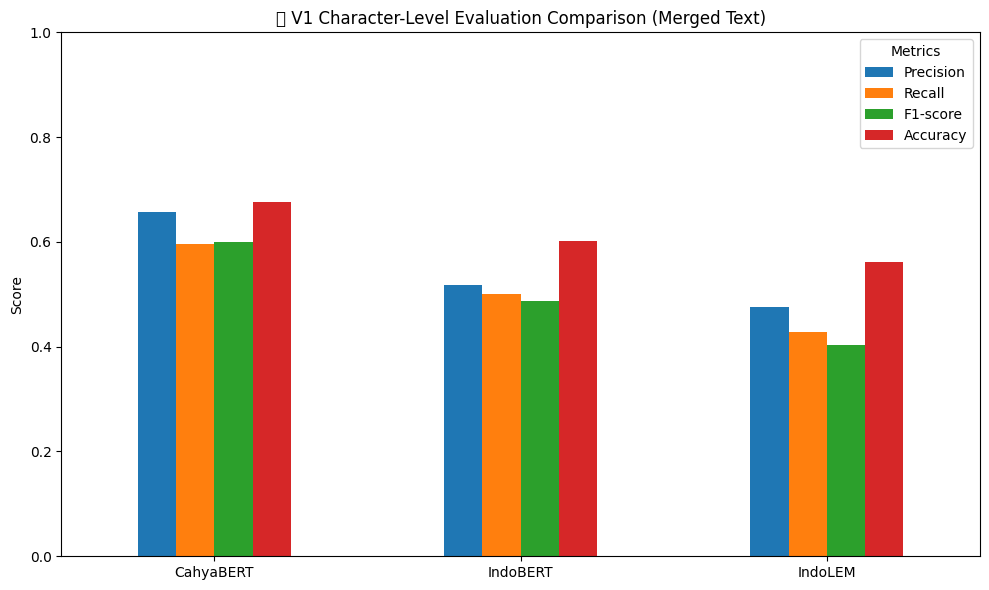

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# === Define model summary paths ===
model_paths = {
    "IndoBERT": "results/V1_IndoBERT_Char/summary.csv",
    "CahyaBERT": "results/V1_CahyaBERT_Char/summary.csv",
    "IndoLEM": "results/V1_IndoLEM_Char/summary.csv"
}

# === Load and extract average metrics ===
summary_data = {}
for model_name, path in model_paths.items():
    df = pd.read_csv(path)

    # Normalize Fold column
    if "Fold" in df.columns:
        df["Fold"] = df["Fold"].astype(str)
        avg_row = df[df["Fold"].str.lower() == "average"]
        if avg_row.empty:
            avg_row = df.tail(1)
    else:
        avg_row = df.tail(1)

    # Normalize column names
    col_map = {col.lower().replace("-", "").replace("_", ""): col for col in df.columns}
    summary_data[model_name] = {
        "Precision": avg_row[col_map.get("precision", "Precision")].values[0],
        "Recall": avg_row[col_map.get("recall", "Recall")].values[0],
        "F1-score": avg_row[col_map.get("f1score", "F1-score")].values[0],
        "Accuracy": avg_row[col_map.get("accuracy", "Accuracy")].values[0],
    }

# === Create leaderboard DataFrame ===
leaderboard_df = pd.DataFrame.from_dict(summary_data, orient="index")
leaderboard_df = leaderboard_df.sort_values(by="F1-score", ascending=False)

# === Display leaderboard ===
print("🏆 V1 Character-Level Leaderboard (Merged Text):")
print(leaderboard_df.round(4))

# === Bar plot comparison ===
leaderboard_df.plot(kind="bar", figsize=(10, 6))
plt.title("📊 V1 Character-Level Evaluation Comparison (Merged Text)")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(title="Metrics")
plt.tight_layout()
plt.savefig("results/V1_Character_Model_Comparison.png")
plt.show()


## V2: IndoBERT merge text + numerical feature

In [ ]:
# === IndoBERT V2: Character-Level (Merged Text + Numeric) ===

import os
import pandas as pd
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import Dataset
from transformers import AutoTokenizer, Trainer, TrainingArguments, EarlyStoppingCallback
from transformers import BertModel
import torch.nn as nn
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support

# === Config ===
FOLDS = 5
EPOCHS = 15
BATCH_SIZE = 8
MODEL_NAME = "indobenchmark/indobert-base-p1"
OUTPUT_DIR = "results/V2_IndoBERT_Char"
SEED = 42
os.makedirs(OUTPUT_DIR, exist_ok=True)

# === Seed Control ===
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# === Load and preprocess data ===
df = pd.read_csv("character_level.csv")
df["merged_text"] = df["merged_text"].fillna("")

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df["type"])
texts = df["merged_text"].tolist()

# === Normalize numeric features ===
to_scale = ["mention_count", "word_count"]
scaler = StandardScaler()
df[to_scale] = scaler.fit_transform(df[to_scale])
numeric_cols = ["mention_count", "word_count"]

# === Compute class weights ===
class_counts = np.bincount(labels)
class_weights = len(labels) / (len(class_counts) * class_counts)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# === Dataset ===
class CharacterWithNumericDataset(Dataset):
    def __init__(self, texts, labels, numeric_feats, tokenizer, max_len=128):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_len)
        self.labels = labels
        self.numeric_feats = torch.tensor(numeric_feats, dtype=torch.float)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        item["numeric_feats"] = self.numeric_feats[idx]
        return item

    def __len__(self):
        return len(self.labels)

# === Model ===
class BERTWithNumeric(nn.Module):
    def __init__(self, model_name, num_labels, num_numeric_features, class_weights):
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size + num_numeric_features, num_labels)
        self.loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    def forward(self, input_ids, attention_mask, numeric_feats, labels=None):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = bert_output.pooler_output
        combined = torch.cat((pooled_output, numeric_feats), dim=1)
        logits = self.classifier(self.dropout(combined))

        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)

        return {"loss": loss, "logits": logits}

# === Custom Collator ===
class CustomCollator:
    def __call__(self, batch):
        input_ids = torch.stack([item["input_ids"] for item in batch])
        attention_mask = torch.stack([item["attention_mask"] for item in batch])
        labels = torch.stack([item["labels"] for item in batch])
        numeric_feats = torch.stack([item["numeric_feats"] for item in batch])
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
            "numeric_feats": numeric_feats
        }

# === Metrics ===
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# === Tokenizer ===
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# === K-Fold CV ===
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
fold_metrics = []
cumulative_cm = np.zeros((3, 3), dtype=int)

for fold, (train_idx, val_idx) in enumerate(skf.split(texts, labels)):
    print(f"\n📚 Fold {fold + 1}/{FOLDS}")

    train_texts = [texts[i] for i in train_idx]
    val_texts = [texts[i] for i in val_idx]
    train_labels = [labels[i] for i in train_idx]
    val_labels = [labels[i] for i in val_idx]

    train_numeric = df.iloc[train_idx][numeric_cols].values
    val_numeric = df.iloc[val_idx][numeric_cols].values

    train_dataset = CharacterWithNumericDataset(train_texts, train_labels, train_numeric, tokenizer)
    val_dataset = CharacterWithNumericDataset(val_texts, val_labels, val_numeric, tokenizer)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = BERTWithNumeric(MODEL_NAME, num_labels=3, num_numeric_features=2, class_weights=class_weights_tensor.to(device))

    fold_dir = os.path.join(OUTPUT_DIR, f"fold_{fold+1}")
    os.makedirs(fold_dir, exist_ok=True)

    training_args = TrainingArguments(
        output_dir=fold_dir,
        num_train_epochs=EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        logging_dir=os.path.join(fold_dir, "logs"),
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        logging_steps=50,
        disable_tqdm=True,
        learning_rate=2e-5,
        warmup_steps=100,
        weight_decay=0.01,
        seed=SEED
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=CustomCollator(),
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    trainer.train()

    # Evaluate
    predictions = trainer.predict(val_dataset)
    preds = torch.argmax(torch.tensor(predictions.predictions), dim=1).numpy()
    true_labels = np.array(val_labels)
    pred_labels = preds

    decoded_true = label_encoder.inverse_transform(true_labels)
    decoded_pred = label_encoder.inverse_transform(pred_labels)

    report = classification_report(decoded_true, decoded_pred, output_dict=True, digits=4)
    report_df = pd.DataFrame(report).transpose()
    report_df.to_csv(os.path.join(fold_dir, "classification_report.csv"))

    cm = confusion_matrix(decoded_true, decoded_pred, labels=label_encoder.classes_)
    cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)
    cumulative_cm += cm

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - Fold {fold + 1} (IndoBERT V2 - Char Level)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(os.path.join(fold_dir, "confusion_matrix.png"))
    plt.close()

    macro = report["macro avg"]
    fold_metrics.append({
        "Fold": fold + 1,
        "Precision": macro["precision"],
        "Recall": macro["recall"],
        "F1": macro["f1-score"],
        "Accuracy": accuracy_score(decoded_true, decoded_pred)
    })

# === Summary ===
summary_df = pd.DataFrame(fold_metrics)
summary_df.loc["Average"] = summary_df.mean(numeric_only=True)
summary_df.to_csv(os.path.join(OUTPUT_DIR, "summary.csv"), index=False)

avg_cm = cumulative_cm // FOLDS
avg_cm_df = pd.DataFrame(avg_cm, index=label_encoder.classes_, columns=label_encoder.classes_)
plt.figure(figsize=(6, 5))
sns.heatmap(avg_cm_df, annot=True, fmt='d', cmap='Purples')
plt.title("Average Confusion Matrix (5-Fold - IndoBERT V2 - Char Level)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "average_confusion_matrix.png"))
plt.close()

print("\n✅ IndoBERT V2 character-level training complete. Results saved to:", OUTPUT_DIR)
print(summary_df)

c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



📚 Fold 1/5


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'eval_loss': 1.0928058624267578, 'eval_accuracy': 0.4358974358974359, 'eval_f1': 0.4045977011494253, 'eval_precision': 0.4604377104377104, 'eval_recall': 0.4593406593406593, 'eval_runtime': 0.2262, 'eval_samples_per_second': 172.394, 'eval_steps_per_second': 22.102, 'epoch': 1.0}
{'eval_loss': 1.0472323894500732, 'eval_accuracy': 0.48717948717948717, 'eval_f1': 0.42512967512967514, 'eval_precision': 0.4527777777777778, 'eval_recall': 0.43052503052503055, 'eval_runtime': 0.1857, 'eval_samples_per_second': 209.985, 'eval_steps_per_second': 26.921, 'epoch': 2.0}
{'loss': 1.0817, 'grad_norm': 7.807872772216797, 'learning_rate': 1e-05, 'epoch': 2.6315789473684212}
{'eval_loss': 1.0796692371368408, 'eval_accuracy': 0.46153846153846156, 'eval_f1': 0.39586983065243936, 'eval_precision': 0.3896825396825397, 'eval_recall': 0.4166056166056166, 'eval_runtime': 0.2017, 'eval_samples_per_second': 193.399, 'eval_steps_per_second': 24.795, 'epoch': 3.0}
{'eval_loss': 1.0044111013412476, 'eval_accurac

c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'eval_loss': 1.1019494533538818, 'eval_accuracy': 0.5, 'eval_f1': 0.3667538506248184, 'eval_precision': 0.37280701754385964, 'eval_recall': 0.3849206349206349, 'eval_runtime': 0.2106, 'eval_samples_per_second': 180.406, 'eval_steps_per_second': 23.738, 'epoch': 1.0}
{'eval_loss': 1.0321533679962158, 'eval_accuracy': 0.5526315789473685, 'eval_f1': 0.4761904761904762, 'eval_precision': 0.6805555555555555, 'eval_recall': 0.45555555555555555, 'eval_runtime': 0.179, 'eval_samples_per_second': 212.325, 'eval_steps_per_second': 27.937, 'epoch': 2.0}
{'loss': 1.0856, 'grad_norm': 13.534708023071289, 'learning_rate': 1e-05, 'epoch': 2.5}


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.0109543800354004, 'eval_accuracy': 0.5263157894736842, 'eval_f1': 0.36015325670498083, 'eval_precision': 0.3398692810457516, 'eval_recall': 0.38888888888888884, 'eval_runtime': 0.1814, 'eval_samples_per_second': 209.536, 'eval_steps_per_second': 27.571, 'epoch': 3.0}
{'eval_loss': 0.875551700592041, 'eval_accuracy': 0.631578947368421, 'eval_f1': 0.5938264633916809, 'eval_precision': 0.5865800865800866, 'eval_recall': 0.6047619047619047, 'eval_runtime': 0.1509, 'eval_samples_per_second': 251.835, 'eval_steps_per_second': 33.136, 'epoch': 4.0}
{'loss': 0.8099, 'grad_norm': 38.19603729248047, 'learning_rate': 2e-05, 'epoch': 5.0}
{'eval_loss': 0.9496976733207703, 'eval_accuracy': 0.5526315789473685, 'eval_f1': 0.4583255524431995, 'eval_precision': 0.4666666666666666, 'eval_recall': 0.5095238095238096, 'eval_runtime': 0.1412, 'eval_samples_per_second': 269.109, 'eval_steps_per_second': 35.409, 'epoch': 5.0}
{'eval_loss': 0.8686912655830383, 'eval_accuracy': 0.60526315789473

c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'eval_loss': 1.1037224531173706, 'eval_accuracy': 0.4473684210526316, 'eval_f1': 0.34385964912280703, 'eval_precision': 0.36349924585218707, 'eval_recall': 0.32936507936507936, 'eval_runtime': 0.1574, 'eval_samples_per_second': 241.407, 'eval_steps_per_second': 31.764, 'epoch': 1.0}
{'eval_loss': 1.0021480321884155, 'eval_accuracy': 0.5789473684210527, 'eval_f1': 0.41135925006892754, 'eval_precision': 0.3996101364522417, 'eval_recall': 0.4444444444444444, 'eval_runtime': 0.1794, 'eval_samples_per_second': 211.784, 'eval_steps_per_second': 27.866, 'epoch': 2.0}
{'loss': 1.0922, 'grad_norm': 8.0380220413208, 'learning_rate': 1e-05, 'epoch': 2.5}
{'eval_loss': 0.9598384499549866, 'eval_accuracy': 0.631578947368421, 'eval_f1': 0.48892230576441104, 'eval_precision': 0.5755336617405583, 'eval_recall': 0.4793650793650794, 'eval_runtime': 0.1756, 'eval_samples_per_second': 216.46, 'eval_steps_per_second': 28.482, 'epoch': 3.0}
{'eval_loss': 0.9714931845664978, 'eval_accuracy': 0.5526315789473

c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'eval_loss': 1.0792902708053589, 'eval_accuracy': 0.47368421052631576, 'eval_f1': 0.3397813288477713, 'eval_precision': 0.4181034482758621, 'eval_recall': 0.4166666666666667, 'eval_runtime': 0.1739, 'eval_samples_per_second': 218.576, 'eval_steps_per_second': 28.76, 'epoch': 1.0}
{'eval_loss': 1.0331928730010986, 'eval_accuracy': 0.5263157894736842, 'eval_f1': 0.3694083694083694, 'eval_precision': 0.3800322061191626, 'eval_recall': 0.36507936507936506, 'eval_runtime': 0.1639, 'eval_samples_per_second': 231.858, 'eval_steps_per_second': 30.508, 'epoch': 2.0}
{'loss': 1.0599, 'grad_norm': 12.1351957321167, 'learning_rate': 1e-05, 'epoch': 2.5}
{'eval_loss': 1.0389174222946167, 'eval_accuracy': 0.631578947368421, 'eval_f1': 0.46428571428571425, 'eval_precision': 0.4506578947368421, 'eval_recall': 0.48809523809523814, 'eval_runtime': 0.177, 'eval_samples_per_second': 214.65, 'eval_steps_per_second': 28.243, 'epoch': 3.0}
{'eval_loss': 1.2403236627578735, 'eval_accuracy': 0.447368421052631

c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'eval_loss': 1.1039416790008545, 'eval_accuracy': 0.3157894736842105, 'eval_f1': 0.25336021505376344, 'eval_precision': 0.27432216905901113, 'eval_recall': 0.26282051282051283, 'eval_runtime': 0.1794, 'eval_samples_per_second': 211.862, 'eval_steps_per_second': 27.877, 'epoch': 1.0}
{'eval_loss': 1.103592872619629, 'eval_accuracy': 0.5, 'eval_f1': 0.3462962962962963, 'eval_precision': 0.3381818181818182, 'eval_recall': 0.36153846153846153, 'eval_runtime': 0.1671, 'eval_samples_per_second': 227.471, 'eval_steps_per_second': 29.93, 'epoch': 2.0}
{'loss': 1.0446, 'grad_norm': 8.744224548339844, 'learning_rate': 1e-05, 'epoch': 2.5}
{'eval_loss': 1.1267839670181274, 'eval_accuracy': 0.4473684210526316, 'eval_f1': 0.30511463844797176, 'eval_precision': 0.2922077922077922, 'eval_recall': 0.31923076923076926, 'eval_runtime': 0.174, 'eval_samples_per_second': 218.355, 'eval_steps_per_second': 28.731, 'epoch': 3.0}
{'eval_loss': 1.146850347518921, 'eval_accuracy': 0.4473684210526316, 'eval_f1'

In [2]:
import os
import shutil

base_path = "results/V2_IndoBERT_Char"

# Loop through each fold
for i in range(1, 6):
    fold_path = os.path.join(base_path, f"fold_{i}")
    deleted = 0

    # Delete folders that start with 'checkpoint'
    for item in os.listdir(fold_path):
        item_path = os.path.join(fold_path, item)
        if os.path.isdir(item_path) and item.startswith("checkpoint"):
            try:
                shutil.rmtree(item_path)
                deleted += 1
            except Exception as e:
                print(f"❌ Failed to delete {item_path}: {e}")

    print(f"✅ Deleted {deleted} checkpoint folders in: {fold_path}")


✅ Deleted 6 checkpoint folders in: results/V2_IndoBERT_Char\fold_1
✅ Deleted 6 checkpoint folders in: results/V2_IndoBERT_Char\fold_2
✅ Deleted 7 checkpoint folders in: results/V2_IndoBERT_Char\fold_3
✅ Deleted 7 checkpoint folders in: results/V2_IndoBERT_Char\fold_4
✅ Deleted 4 checkpoint folders in: results/V2_IndoBERT_Char\fold_5


## V2: CahyaBERT merge text + numerical feature

In [1]:
# === IndoBERT V2: Character-Level (Merged Text + Numeric) ===

import os
import pandas as pd
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import Dataset
from transformers import AutoTokenizer, Trainer, TrainingArguments, EarlyStoppingCallback
from transformers import BertModel
import torch.nn as nn
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support

# === Config ===
FOLDS = 5
EPOCHS = 15
BATCH_SIZE = 8
MODEL_NAME = "cahya/bert-base-indonesian-1.5G"
OUTPUT_DIR = "results/V2_CahyaBERT_Char"
SEED = 42
os.makedirs(OUTPUT_DIR, exist_ok=True)

# === Seed Control ===
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# === Load and preprocess data ===
df = pd.read_csv("character_level.csv")
df["merged_text"] = df["merged_text"].fillna("")

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df["type"])
texts = df["merged_text"].tolist()

# === Normalize numeric features ===
to_scale = ["mention_count", "word_count"]
scaler = StandardScaler()
df[to_scale] = scaler.fit_transform(df[to_scale])
numeric_cols = ["mention_count", "word_count"]

# === Compute class weights ===
class_counts = np.bincount(labels)
class_weights = len(labels) / (len(class_counts) * class_counts)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# === Dataset ===
class CharacterWithNumericDataset(Dataset):
    def __init__(self, texts, labels, numeric_feats, tokenizer, max_len=128):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_len)
        self.labels = labels
        self.numeric_feats = torch.tensor(numeric_feats, dtype=torch.float)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        item["numeric_feats"] = self.numeric_feats[idx]
        return item

    def __len__(self):
        return len(self.labels)

# === Model ===
class BERTWithNumeric(nn.Module):
    def __init__(self, model_name, num_labels, num_numeric_features, class_weights):
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size + num_numeric_features, num_labels)
        self.loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    def forward(self, input_ids, attention_mask, numeric_feats, labels=None):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = bert_output.pooler_output
        combined = torch.cat((pooled_output, numeric_feats), dim=1)
        logits = self.classifier(self.dropout(combined))

        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)

        return {"loss": loss, "logits": logits}

# === Custom Collator ===
class CustomCollator:
    def __call__(self, batch):
        input_ids = torch.stack([item["input_ids"] for item in batch])
        attention_mask = torch.stack([item["attention_mask"] for item in batch])
        labels = torch.stack([item["labels"] for item in batch])
        numeric_feats = torch.stack([item["numeric_feats"] for item in batch])
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
            "numeric_feats": numeric_feats
        }

# === Metrics ===
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# === Tokenizer ===
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# === K-Fold CV ===
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
fold_metrics = []
cumulative_cm = np.zeros((3, 3), dtype=int)

for fold, (train_idx, val_idx) in enumerate(skf.split(texts, labels)):
    print(f"\n📚 Fold {fold + 1}/{FOLDS}")

    train_texts = [texts[i] for i in train_idx]
    val_texts = [texts[i] for i in val_idx]
    train_labels = [labels[i] for i in train_idx]
    val_labels = [labels[i] for i in val_idx]

    train_numeric = df.iloc[train_idx][numeric_cols].values
    val_numeric = df.iloc[val_idx][numeric_cols].values

    train_dataset = CharacterWithNumericDataset(train_texts, train_labels, train_numeric, tokenizer)
    val_dataset = CharacterWithNumericDataset(val_texts, val_labels, val_numeric, tokenizer)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = BERTWithNumeric(MODEL_NAME, num_labels=3, num_numeric_features=2, class_weights=class_weights_tensor.to(device))

    fold_dir = os.path.join(OUTPUT_DIR, f"fold_{fold+1}")
    os.makedirs(fold_dir, exist_ok=True)

    training_args = TrainingArguments(
        output_dir=fold_dir,
        num_train_epochs=EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        logging_dir=os.path.join(fold_dir, "logs"),
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        logging_steps=50,
        disable_tqdm=True,
        learning_rate=2e-5,
        warmup_steps=100,
        weight_decay=0.01,
        seed=SEED
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=CustomCollator(),
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    trainer.train()

    # Evaluate
    predictions = trainer.predict(val_dataset)
    preds = torch.argmax(torch.tensor(predictions.predictions), dim=1).numpy()
    true_labels = np.array(val_labels)
    pred_labels = preds

    decoded_true = label_encoder.inverse_transform(true_labels)
    decoded_pred = label_encoder.inverse_transform(pred_labels)

    report = classification_report(decoded_true, decoded_pred, output_dict=True, digits=4)
    report_df = pd.DataFrame(report).transpose()
    report_df.to_csv(os.path.join(fold_dir, "classification_report.csv"))

    cm = confusion_matrix(decoded_true, decoded_pred, labels=label_encoder.classes_)
    cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)
    cumulative_cm += cm

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - Fold {fold + 1} (CahyaBERT V2 - Char Level)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(os.path.join(fold_dir, "confusion_matrix.png"))
    plt.close()

    macro = report["macro avg"]
    fold_metrics.append({
        "Fold": fold + 1,
        "Precision": macro["precision"],
        "Recall": macro["recall"],
        "F1": macro["f1-score"],
        "Accuracy": accuracy_score(decoded_true, decoded_pred)
    })

# === Summary ===
summary_df = pd.DataFrame(fold_metrics)
summary_df.loc["Average"] = summary_df.mean(numeric_only=True)
summary_df.to_csv(os.path.join(OUTPUT_DIR, "summary.csv"), index=False)

avg_cm = cumulative_cm // FOLDS
avg_cm_df = pd.DataFrame(avg_cm, index=label_encoder.classes_, columns=label_encoder.classes_)
plt.figure(figsize=(6, 5))
sns.heatmap(avg_cm_df, annot=True, fmt='d', cmap='Purples')
plt.title("Average Confusion Matrix (5-Fold - CahyaBERT V2 - Char Level)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "average_confusion_matrix.png"))
plt.close()

print("\n✅ CahyaBERT V2 character-level training complete. Results saved to:", OUTPUT_DIR)

# Show final evaluation metrics
print("\n📊 Final Evaluation Summary (Average Across Folds):\n")
print(summary_df.loc["Average"][["Precision", "Recall", "F1", "Accuracy"]].round(4))


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



📚 Fold 1/5


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.1046069860458374, 'eval_accuracy': 0.358974358974359, 'eval_f1': 0.20023767082590613, 'eval_precision': 0.4473684210526316, 'eval_recall': 0.34920634920634924, 'eval_runtime': 0.2016, 'eval_samples_per_second': 193.454, 'eval_steps_per_second': 24.802, 'epoch': 1.0}


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.0538806915283203, 'eval_accuracy': 0.5641025641025641, 'eval_f1': 0.3701814058956916, 'eval_precision': 0.3538961038961039, 'eval_recall': 0.398046398046398, 'eval_runtime': 0.1827, 'eval_samples_per_second': 213.487, 'eval_steps_per_second': 27.37, 'epoch': 2.0}
{'loss': 1.0881, 'grad_norm': 7.813492774963379, 'learning_rate': 1e-05, 'epoch': 2.6315789473684212}
{'eval_loss': 1.0177555084228516, 'eval_accuracy': 0.5128205128205128, 'eval_f1': 0.47719298245614034, 'eval_precision': 0.4862745098039216, 'eval_recall': 0.4776556776556777, 'eval_runtime': 0.1812, 'eval_samples_per_second': 215.187, 'eval_steps_per_second': 27.588, 'epoch': 3.0}
{'eval_loss': 0.9971977472305298, 'eval_accuracy': 0.5897435897435898, 'eval_f1': 0.4795434969853574, 'eval_precision': 0.4963924963924964, 'eval_recall': 0.4744810744810744, 'eval_runtime': 0.2051, 'eval_samples_per_second': 190.136, 'eval_steps_per_second': 24.376, 'epoch': 4.0}
{'eval_loss': 0.9385798573493958, 'eval_accuracy': 0.

c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'eval_loss': 1.0941054821014404, 'eval_accuracy': 0.39473684210526316, 'eval_f1': 0.336024336024336, 'eval_precision': 0.34722222222222215, 'eval_recall': 0.3365079365079365, 'eval_runtime': 0.2034, 'eval_samples_per_second': 186.781, 'eval_steps_per_second': 24.576, 'epoch': 1.0}


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.0725644826889038, 'eval_accuracy': 0.5263157894736842, 'eval_f1': 0.37625861155272916, 'eval_precision': 0.38974358974358975, 'eval_recall': 0.4365079365079365, 'eval_runtime': 0.1886, 'eval_samples_per_second': 201.454, 'eval_steps_per_second': 26.507, 'epoch': 2.0}
{'loss': 1.1085, 'grad_norm': 10.08932876586914, 'learning_rate': 1e-05, 'epoch': 2.5}
{'eval_loss': 1.0339330434799194, 'eval_accuracy': 0.47368421052631576, 'eval_f1': 0.3263246425567704, 'eval_precision': 0.31470588235294117, 'eval_recall': 0.3452380952380953, 'eval_runtime': 0.172, 'eval_samples_per_second': 220.976, 'eval_steps_per_second': 29.076, 'epoch': 3.0}
{'eval_loss': 0.9434431195259094, 'eval_accuracy': 0.6578947368421053, 'eval_f1': 0.5939571150097466, 'eval_precision': 0.6170634920634921, 'eval_recall': 0.6087301587301587, 'eval_runtime': 0.17, 'eval_samples_per_second': 223.497, 'eval_steps_per_second': 29.408, 'epoch': 4.0}
{'loss': 0.7854, 'grad_norm': 9.894837379455566, 'learning_rate': 

c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'eval_loss': 1.0792983770370483, 'eval_accuracy': 0.3684210526315789, 'eval_f1': 0.3625005441643812, 'eval_precision': 0.4222222222222222, 'eval_recall': 0.5119047619047619, 'eval_runtime': 0.193, 'eval_samples_per_second': 196.869, 'eval_steps_per_second': 25.904, 'epoch': 1.0}
{'eval_loss': 1.0480180978775024, 'eval_accuracy': 0.5526315789473685, 'eval_f1': 0.38183347350714886, 'eval_precision': 0.36764705882352944, 'eval_recall': 0.4047619047619048, 'eval_runtime': 0.1746, 'eval_samples_per_second': 217.687, 'eval_steps_per_second': 28.643, 'epoch': 2.0}
{'loss': 1.0826, 'grad_norm': 8.097698211669922, 'learning_rate': 1e-05, 'epoch': 2.5}


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.972531795501709, 'eval_accuracy': 0.5789473684210527, 'eval_f1': 0.3810386473429952, 'eval_precision': 0.361391694725028, 'eval_recall': 0.4087301587301588, 'eval_runtime': 0.191, 'eval_samples_per_second': 198.926, 'eval_steps_per_second': 26.175, 'epoch': 3.0}
{'eval_loss': 0.8803847432136536, 'eval_accuracy': 0.6842105263157895, 'eval_f1': 0.5777777777777778, 'eval_precision': 0.7807017543859649, 'eval_recall': 0.5706349206349206, 'eval_runtime': 0.1782, 'eval_samples_per_second': 213.206, 'eval_steps_per_second': 28.053, 'epoch': 4.0}
{'loss': 0.8119, 'grad_norm': 12.16065502166748, 'learning_rate': 2e-05, 'epoch': 5.0}
{'eval_loss': 0.7154113054275513, 'eval_accuracy': 0.6578947368421053, 'eval_f1': 0.6290143964562569, 'eval_precision': 0.6180856180856181, 'eval_recall': 0.6595238095238095, 'eval_runtime': 0.0957, 'eval_samples_per_second': 397.021, 'eval_steps_per_second': 52.24, 'epoch': 5.0}
{'eval_loss': 0.8164384961128235, 'eval_accuracy': 0.7105263157894737, 

c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'eval_loss': 1.0947870016098022, 'eval_accuracy': 0.4473684210526316, 'eval_f1': 0.40321769733534435, 'eval_precision': 0.5023809523809524, 'eval_recall': 0.4968253968253969, 'eval_runtime': 0.1823, 'eval_samples_per_second': 208.5, 'eval_steps_per_second': 27.434, 'epoch': 1.0}
{'eval_loss': 1.0683311223983765, 'eval_accuracy': 0.6052631578947368, 'eval_f1': 0.43747893495112905, 'eval_precision': 0.4393939393939394, 'eval_recall': 0.4365079365079365, 'eval_runtime': 0.1398, 'eval_samples_per_second': 271.839, 'eval_steps_per_second': 35.768, 'epoch': 2.0}
{'loss': 1.0786, 'grad_norm': 9.678706169128418, 'learning_rate': 1e-05, 'epoch': 2.5}


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.0376487970352173, 'eval_accuracy': 0.6052631578947368, 'eval_f1': 0.4300903774587985, 'eval_precision': 0.4136321195144725, 'eval_recall': 0.4841269841269842, 'eval_runtime': 0.1644, 'eval_samples_per_second': 231.155, 'eval_steps_per_second': 30.415, 'epoch': 3.0}
{'eval_loss': 1.041115164756775, 'eval_accuracy': 0.5, 'eval_f1': 0.44095532950022115, 'eval_precision': 0.5174019607843138, 'eval_recall': 0.4896825396825397, 'eval_runtime': 0.1662, 'eval_samples_per_second': 228.631, 'eval_steps_per_second': 30.083, 'epoch': 4.0}
{'loss': 0.767, 'grad_norm': 7.554291725158691, 'learning_rate': 2e-05, 'epoch': 5.0}
{'eval_loss': 1.138381004333496, 'eval_accuracy': 0.5526315789473685, 'eval_f1': 0.49112749112749104, 'eval_precision': 0.73, 'eval_recall': 0.515079365079365, 'eval_runtime': 0.1238, 'eval_samples_per_second': 307.021, 'eval_steps_per_second': 40.398, 'epoch': 5.0}
{'eval_loss': 1.3334976434707642, 'eval_accuracy': 0.5526315789473685, 'eval_f1': 0.49237472766884

c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.0976380109786987, 'eval_accuracy': 0.5526315789473685, 'eval_f1': 0.31299927378358755, 'eval_precision': 0.35294117647058826, 'eval_recall': 0.367948717948718, 'eval_runtime': 0.1596, 'eval_samples_per_second': 238.039, 'eval_steps_per_second': 31.321, 'epoch': 1.0}


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.0806934833526611, 'eval_accuracy': 0.5526315789473685, 'eval_f1': 0.38888888888888884, 'eval_precision': 0.3684210526315789, 'eval_recall': 0.4217948717948718, 'eval_runtime': 0.1601, 'eval_samples_per_second': 237.346, 'eval_steps_per_second': 31.23, 'epoch': 2.0}
{'loss': 1.0706, 'grad_norm': 9.18968391418457, 'learning_rate': 1e-05, 'epoch': 2.5}
{'eval_loss': 1.0886441469192505, 'eval_accuracy': 0.5, 'eval_f1': 0.34545454545454546, 'eval_precision': 0.3333333333333333, 'eval_recall': 0.36153846153846153, 'eval_runtime': 0.1618, 'eval_samples_per_second': 234.858, 'eval_steps_per_second': 30.902, 'epoch': 3.0}
{'eval_loss': 1.0964604616165161, 'eval_accuracy': 0.5789473684210527, 'eval_f1': 0.4789473684210526, 'eval_precision': 0.48148148148148157, 'eval_recall': 0.4794871794871794, 'eval_runtime': 0.1363, 'eval_samples_per_second': 278.822, 'eval_steps_per_second': 36.687, 'epoch': 4.0}
{'loss': 0.7434, 'grad_norm': 55.206424713134766, 'learning_rate': 2e-05, 'epoch

In [2]:
import os
import shutil

base_path = "results/V2_CahyaBERT_Char"

# Loop through each fold directory
for i in range(1, 6):
    fold_path = os.path.join(base_path, f"fold_{i}")
    deleted = 0

    if not os.path.exists(fold_path):
        print(f"⚠️ Folder not found: {fold_path}")
        continue

    for item in os.listdir(fold_path):
        item_path = os.path.join(fold_path, item)
        if os.path.isdir(item_path) and item.startswith("checkpoint"):
            try:
                shutil.rmtree(item_path)
                deleted += 1
            except Exception as e:
                print(f"❌ Failed to delete {item_path}: {e}")

    print(f"✅ Deleted {deleted} checkpoint folders in: {fold_path}")


✅ Deleted 2 checkpoint folders in: results/V2_CahyaBERT_Char\fold_1
✅ Deleted 0 checkpoint folders in: results/V2_CahyaBERT_Char\fold_2
✅ Deleted 0 checkpoint folders in: results/V2_CahyaBERT_Char\fold_3
✅ Deleted 0 checkpoint folders in: results/V2_CahyaBERT_Char\fold_4
✅ Deleted 0 checkpoint folders in: results/V2_CahyaBERT_Char\fold_5


## V2: IndoLEM merge text + numerical feature

In [ ]:
# === IndoLEM V2: Character-Level (Merged Text + Numeric) ===

import os
import pandas as pd
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import Dataset
from transformers import AutoTokenizer, Trainer, TrainingArguments, EarlyStoppingCallback
from transformers import BertModel
import torch.nn as nn
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support

# === Config ===
FOLDS = 5
EPOCHS = 15
BATCH_SIZE = 8
MODEL_NAME = "indolem/indobert-base-uncased"
OUTPUT_DIR = "results/V2_IndoLEM_Char"
SEED = 42
os.makedirs(OUTPUT_DIR, exist_ok=True)

# === Seed Control ===
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# === Load and preprocess data ===
df = pd.read_csv("character_level.csv")
df["merged_text"] = df["merged_text"].fillna("")

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df["type"])
texts = df["merged_text"].tolist()

# === Normalize numeric features ===
to_scale = ["mention_count", "word_count"]
scaler = StandardScaler()
df[to_scale] = scaler.fit_transform(df[to_scale])
numeric_cols = ["mention_count", "word_count"]

# === Compute class weights ===
class_counts = np.bincount(labels)
class_weights = len(labels) / (len(class_counts) * class_counts)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# === Dataset ===
class CharacterWithNumericDataset(Dataset):
    def __init__(self, texts, labels, numeric_feats, tokenizer, max_len=128):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_len)
        self.labels = labels
        self.numeric_feats = torch.tensor(numeric_feats, dtype=torch.float)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        item["numeric_feats"] = self.numeric_feats[idx]
        return item

    def __len__(self):
        return len(self.labels)

# === Model ===
class BERTWithNumeric(nn.Module):
    def __init__(self, model_name, num_labels, num_numeric_features, class_weights):
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size + num_numeric_features, num_labels)
        self.loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    def forward(self, input_ids, attention_mask, numeric_feats, labels=None):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = bert_output.pooler_output
        combined = torch.cat((pooled_output, numeric_feats), dim=1)
        logits = self.classifier(self.dropout(combined))

        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)

        return {"loss": loss, "logits": logits}

# === Custom Collator ===
class CustomCollator:
    def __call__(self, batch):
        input_ids = torch.stack([item["input_ids"] for item in batch])
        attention_mask = torch.stack([item["attention_mask"] for item in batch])
        labels = torch.stack([item["labels"] for item in batch])
        numeric_feats = torch.stack([item["numeric_feats"] for item in batch])
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
            "numeric_feats": numeric_feats
        }

# === Metrics ===
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# === Tokenizer ===
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# === K-Fold CV ===
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
fold_metrics = []
cumulative_cm = np.zeros((3, 3), dtype=int)

for fold, (train_idx, val_idx) in enumerate(skf.split(texts, labels)):
    print(f"\n📚 Fold {fold + 1}/{FOLDS}")

    train_texts = [texts[i] for i in train_idx]
    val_texts = [texts[i] for i in val_idx]
    train_labels = [labels[i] for i in train_idx]
    val_labels = [labels[i] for i in val_idx]

    train_numeric = df.iloc[train_idx][numeric_cols].values
    val_numeric = df.iloc[val_idx][numeric_cols].values

    train_dataset = CharacterWithNumericDataset(train_texts, train_labels, train_numeric, tokenizer)
    val_dataset = CharacterWithNumericDataset(val_texts, val_labels, val_numeric, tokenizer)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = BERTWithNumeric(MODEL_NAME, num_labels=3, num_numeric_features=2, class_weights=class_weights_tensor.to(device))

    fold_dir = os.path.join(OUTPUT_DIR, f"fold_{fold+1}")
    os.makedirs(fold_dir, exist_ok=True)

    training_args = TrainingArguments(
        output_dir=fold_dir,
        num_train_epochs=EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        logging_dir=os.path.join(fold_dir, "logs"),
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        logging_steps=50,
        disable_tqdm=True,
        learning_rate=2e-5,
        warmup_steps=100,
        weight_decay=0.01,
        seed=SEED
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=CustomCollator(),
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    trainer.train()

    # Evaluate
    predictions = trainer.predict(val_dataset)
    preds = torch.argmax(torch.tensor(predictions.predictions), dim=1).numpy()
    true_labels = np.array(val_labels)
    pred_labels = preds

    decoded_true = label_encoder.inverse_transform(true_labels)
    decoded_pred = label_encoder.inverse_transform(pred_labels)

    report = classification_report(decoded_true, decoded_pred, output_dict=True, digits=4)
    report_df = pd.DataFrame(report).transpose()
    report_df.to_csv(os.path.join(fold_dir, "classification_report.csv"))

    cm = confusion_matrix(decoded_true, decoded_pred, labels=label_encoder.classes_)
    cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)
    cumulative_cm += cm

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - Fold {fold + 1} (IndoLEM V2 - Char Level)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(os.path.join(fold_dir, "confusion_matrix.png"))
    plt.close()

    macro = report["macro avg"]
    fold_metrics.append({
        "Fold": fold + 1,
        "Precision": macro["precision"],
        "Recall": macro["recall"],
        "F1": macro["f1-score"],
        "Accuracy": accuracy_score(decoded_true, decoded_pred)
    })

# === Summary ===
summary_df = pd.DataFrame(fold_metrics)
summary_df.loc["Average"] = summary_df.mean(numeric_only=True)
summary_df.to_csv(os.path.join(OUTPUT_DIR, "summary.csv"), index=False)

avg_cm = cumulative_cm // FOLDS
avg_cm_df = pd.DataFrame(avg_cm, index=label_encoder.classes_, columns=label_encoder.classes_)
plt.figure(figsize=(6, 5))
sns.heatmap(avg_cm_df, annot=True, fmt='d', cmap='Purples')
plt.title("Average Confusion Matrix (5-Fold - IndoLEM V2 - Char Level)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "average_confusion_matrix.png"))
plt.close()

print("\n✅ IndoLEM V2 character-level training complete. Results saved to:", OUTPUT_DIR)

# Show final evaluation metrics
print("\n📊 Final Evaluation Summary (Average Across Folds):\n")
print(summary_df.loc["Average"][["Precision", "Recall", "F1", "Accuracy"]].round(4))


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



📚 Fold 1/5


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'eval_loss': 1.088220238685608, 'eval_accuracy': 0.3333333333333333, 'eval_f1': 0.3051747399573487, 'eval_precision': 0.35555555555555557, 'eval_recall': 0.37826617826617825, 'eval_runtime': 0.1944, 'eval_samples_per_second': 200.652, 'eval_steps_per_second': 25.725, 'epoch': 1.0}
{'eval_loss': 1.0637296438217163, 'eval_accuracy': 0.5384615384615384, 'eval_f1': 0.4782760730833115, 'eval_precision': 0.6814814814814815, 'eval_recall': 0.46227106227106224, 'eval_runtime': 0.149, 'eval_samples_per_second': 261.752, 'eval_steps_per_second': 33.558, 'epoch': 2.0}
{'loss': 1.0686, 'grad_norm': 33.06949234008789, 'learning_rate': 1e-05, 'epoch': 2.6315789473684212}
{'eval_loss': 1.0258853435516357, 'eval_accuracy': 0.5897435897435898, 'eval_f1': 0.5406260406260407, 'eval_precision': 0.5333333333333333, 'eval_recall': 0.5545787545787545, 'eval_runtime': 0.1702, 'eval_samples_per_second': 229.121, 'eval_steps_per_second': 29.375, 'epoch': 3.0}
{'eval_loss': 1.0062227249145508, 'eval_accuracy': 

c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'eval_loss': 1.0905977487564087, 'eval_accuracy': 0.42105263157894735, 'eval_f1': 0.4116285403050109, 'eval_precision': 0.4287878787878788, 'eval_recall': 0.4777777777777778, 'eval_runtime': 0.1895, 'eval_samples_per_second': 200.54, 'eval_steps_per_second': 26.387, 'epoch': 1.0}
{'eval_loss': 1.0640076398849487, 'eval_accuracy': 0.47368421052631576, 'eval_f1': 0.41405114792211567, 'eval_precision': 0.44225146198830406, 'eval_recall': 0.41984126984126985, 'eval_runtime': 0.169, 'eval_samples_per_second': 224.878, 'eval_steps_per_second': 29.589, 'epoch': 2.0}
{'loss': 1.0938, 'grad_norm': 26.436433792114258, 'learning_rate': 1e-05, 'epoch': 2.5}
{'eval_loss': 1.0493619441986084, 'eval_accuracy': 0.4473684210526316, 'eval_f1': 0.40041827541827546, 'eval_precision': 0.47500000000000003, 'eval_recall': 0.39206349206349206, 'eval_runtime': 0.1662, 'eval_samples_per_second': 228.619, 'eval_steps_per_second': 30.081, 'epoch': 3.0}
{'eval_loss': 0.9904641509056091, 'eval_accuracy': 0.5, 'eva

c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.0367798805236816, 'eval_accuracy': 0.5, 'eval_f1': 0.2888888888888889, 'eval_precision': 0.24848484848484845, 'eval_recall': 0.3523809523809524, 'eval_runtime': 0.151, 'eval_samples_per_second': 251.687, 'eval_steps_per_second': 33.117, 'epoch': 1.0}
{'eval_loss': 1.0053248405456543, 'eval_accuracy': 0.5, 'eval_f1': 0.5219662058371736, 'eval_precision': 0.5637681159420289, 'eval_recall': 0.5611111111111111, 'eval_runtime': 0.1674, 'eval_samples_per_second': 226.994, 'eval_steps_per_second': 29.868, 'epoch': 2.0}
{'loss': 1.1037, 'grad_norm': 146.82643127441406, 'learning_rate': 1e-05, 'epoch': 2.5}
{'eval_loss': 0.9381123781204224, 'eval_accuracy': 0.6578947368421053, 'eval_f1': 0.6420014094432699, 'eval_precision': 0.6313131313131314, 'eval_recall': 0.6595238095238095, 'eval_runtime': 0.1771, 'eval_samples_per_second': 214.532, 'eval_steps_per_second': 28.228, 'epoch': 3.0}
{'eval_loss': 0.8968589901924133, 'eval_accuracy': 0.631578947368421, 'eval_f1': 0.6667909288598

c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'eval_loss': 1.1381100416183472, 'eval_accuracy': 0.23684210526315788, 'eval_f1': 0.23794871794871794, 'eval_precision': 0.276923076923077, 'eval_recall': 0.3817460317460317, 'eval_runtime': 0.1387, 'eval_samples_per_second': 274.033, 'eval_steps_per_second': 36.057, 'epoch': 1.0}
{'eval_loss': 1.1075814962387085, 'eval_accuracy': 0.4473684210526316, 'eval_f1': 0.366619535760575, 'eval_precision': 0.3688311688311689, 'eval_recall': 0.3682539682539682, 'eval_runtime': 0.1734, 'eval_samples_per_second': 219.122, 'eval_steps_per_second': 28.832, 'epoch': 2.0}
{'loss': 1.053, 'grad_norm': 16.655057907104492, 'learning_rate': 1e-05, 'epoch': 2.5}
{'eval_loss': 1.0940008163452148, 'eval_accuracy': 0.5263157894736842, 'eval_f1': 0.44928044928044925, 'eval_precision': 0.45138888888888884, 'eval_recall': 0.46349206349206346, 'eval_runtime': 0.1697, 'eval_samples_per_second': 223.907, 'eval_steps_per_second': 29.461, 'epoch': 3.0}
{'eval_loss': 1.1107004880905151, 'eval_accuracy': 0.39473684210

c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'train_runtime': 17.8029, 'train_samples_per_second': 128.911, 'train_steps_per_second': 16.851, 'train_loss': 0.9903897857666015, 'epoch': 5.0}

📚 Fold 5/5


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'eval_loss': 1.0708428621292114, 'eval_accuracy': 0.5, 'eval_f1': 0.51203007518797, 'eval_precision': 0.5148148148148148, 'eval_recall': 0.5115384615384615, 'eval_runtime': 0.1508, 'eval_samples_per_second': 252.016, 'eval_steps_per_second': 33.16, 'epoch': 1.0}
{'eval_loss': 1.0645476579666138, 'eval_accuracy': 0.39473684210526316, 'eval_f1': 0.2843137254901961, 'eval_precision': 0.28273809523809523, 'eval_recall': 0.3038461538461539, 'eval_runtime': 0.1622, 'eval_samples_per_second': 234.28, 'eval_steps_per_second': 30.826, 'epoch': 2.0}
{'loss': 1.0671, 'grad_norm': 14.873758316040039, 'learning_rate': 1e-05, 'epoch': 2.5}
{'eval_loss': 1.057220220565796, 'eval_accuracy': 0.4473684210526316, 'eval_f1': 0.4670348808279843, 'eval_precision': 0.45744301994301995, 'eval_recall': 0.5282051282051282, 'eval_runtime': 0.1617, 'eval_samples_per_second': 235.037, 'eval_steps_per_second': 30.926, 'epoch': 3.0}
{'train_runtime': 10.618, 'train_samples_per_second': 216.143, 'train_steps_per_sec

In [3]:
import os
import shutil

base_path = "results/V2_IndoLEM_Char"

# Loop through each fold
for i in range(1, 6):
    fold_path = os.path.join(base_path, f"fold_{i}")
    deleted = 0

    if not os.path.exists(fold_path):
        print(f"⚠️ Folder not found: {fold_path}")
        continue

    for item in os.listdir(fold_path):
        item_path = os.path.join(fold_path, item)
        if os.path.isdir(item_path) and item.startswith("checkpoint"):
            try:
                shutil.rmtree(item_path)
                deleted += 1
            except Exception as e:
                print(f"❌ Failed to delete {item_path}: {e}")

    print(f"✅ Deleted {deleted} checkpoint folders in: {fold_path}")


✅ Deleted 5 checkpoint folders in: results/V2_IndoLEM_Char\fold_1
✅ Deleted 11 checkpoint folders in: results/V2_IndoLEM_Char\fold_2
✅ Deleted 7 checkpoint folders in: results/V2_IndoLEM_Char\fold_3
✅ Deleted 5 checkpoint folders in: results/V2_IndoLEM_Char\fold_4
✅ Deleted 3 checkpoint folders in: results/V2_IndoLEM_Char\fold_5


## comparison between v2 models


🏆 V2 Leaderboard (Character-Level - Sorted by F1-score):

                Precision  Recall      F1  Accuracy
CahyaBERT 1.5G     0.6670  0.6233  0.6216    0.6652
IndoLEM            0.5487  0.5689  0.5455    0.5653
IndoBERT           0.5014  0.5157  0.5000    0.6023


C:\Users\rayssa\AppData\Local\Temp\ipykernel_19148\1637278207.py:36: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\rayssa\AppData\Local\Temp\ipykernel_19148\1637278207.py:37: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig("results/V2_Model_Leaderboard_F1.png")
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


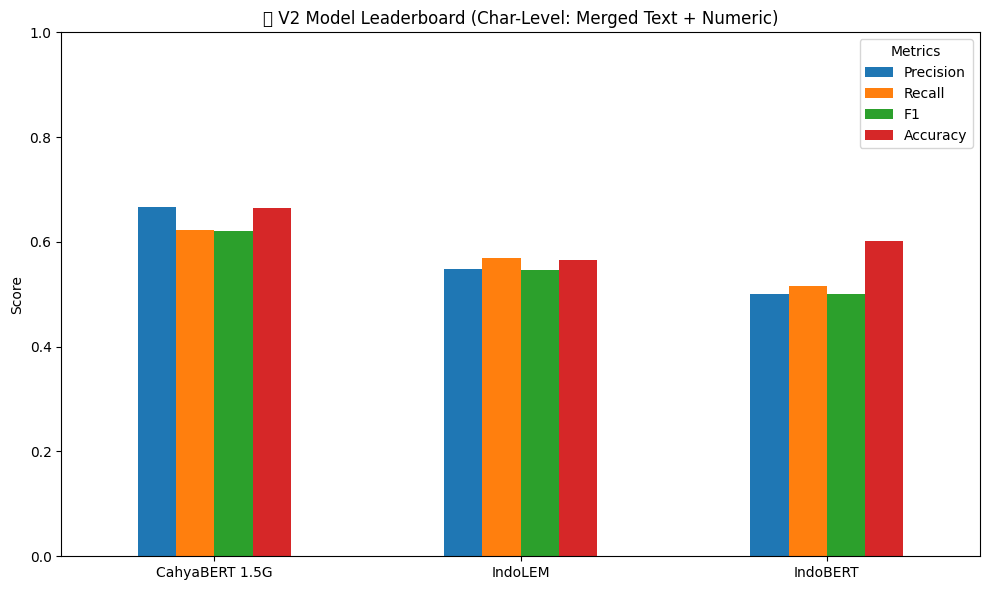

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Define paths to summary files
summary_paths = {
    "IndoBERT": "results/V2_IndoBERT_Char/summary.csv",
    "CahyaBERT 1.5G": "results/V2_CahyaBERT_Char/summary.csv",
    "IndoLEM": "results/V2_IndoLEM_Char/summary.csv"
}

summary_data = {}

for model_name, path in summary_paths.items():
    df = pd.read_csv(path)
    last_row = df.iloc[-1].drop(labels="Fold", errors="ignore")  # Handle cases with or without Fold column
    summary_data[model_name] = last_row

# Create DataFrame
metrics = ["Precision", "Recall", "F1", "Accuracy"]
df_comparison = pd.DataFrame(summary_data, index=metrics).T

# Sort by F1
df_comparison = df_comparison.sort_values(by="F1", ascending=False)

# Display leaderboard
print("\n🏆 V2 Leaderboard (Character-Level - Sorted by F1-score):\n")
print(df_comparison.round(4))

# Plot
df_comparison.plot(kind="bar", figsize=(10, 6))
plt.title("📊 V2 Model Leaderboard (Char-Level: Merged Text + Numeric)")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(title="Metrics")
plt.tight_layout()
plt.savefig("results/V2_Model_Leaderboard_F1.png")
plt.show()
